In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

In [3]:
domain = Hypercube((0., 0.), (1., 1.))
x_dom = array(Sobol(2, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(1, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


In [4]:
class MLP(Module):
    features: Sequence[int]

    @compact
    def __call__(self, x):
        for i, feat in enumerate(self.features[:-1]):
            x = tanh(Dense(feat, name=f'layers_{i}')(x))
        return Dense(self.features[-1], name='output_layer')(x)



In [5]:

model = MLP([16] * 4 + [1])
key, init_key = random.split(random.PRNGKey(503))
params = model.init(init_key, ones((2,)))
del init_key

tx = optax.adam(0.001)
state = TrainState.create(
    apply_fn=model.apply, 
    params=params['params'],
    tx=tx
)

l1 = lambda x, p: laplace(model)(x, p) + sin(2*pi * x[0]) * sin(2*pi * x[1])
l2 = lambda x, p: model.apply(p, x)

def loss(params, x_dom, x_bnd):
    _l1 = mean(vmap(l1, (0, None))(x_dom, params) ** 2)
    _l2 = mean(vmap(l2, (0, None))(x_bnd, params) ** 2)
    _loss = _l1 + _l2
    return _loss, {'pde_loss': _l1, 'bnd_loss': _l2, 'loss': _loss}


@partial(jit, static_argnames="loss")
def train_step(state, loss, *args):
    def _loss(*args, **kwargs):
        out = loss(*args, **kwargs)
        if not isinstance(out, ndarray):
            return (out[0], *out[1:])
        else:
            return out, ()
    (l, metrics), grads = jax.value_and_grad(_loss, has_aux=True)(
        {'params': state.params}, *args #x_dom, x_bnd
    )
    return l, state.apply_gradients(grads=grads['params']), metrics


@partial(jit, static_argnames=("loss", "batch_fun"))
def train_epoch(state, loss, batch_fun, rng):
    # k1, k2 = random.split(rng)
    # batch_size_dom = x_dom.shape[0] // batches
    # batch_size_bnd = x_bnd.shape[0] // batches

    # perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    # perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    # perms_dom = perms_dom.reshape((batches, batch_size_dom))

    # perms_bnd = jax.random.permutation(k2, x_bnd.shape[0])
    # perms_bnd = perms_bnd[:batches * batch_size_bnd]  # skip incomplete batch
    # perms_bnd = perms_bnd.reshape((batches, batch_size_bnd))

    data = batch_fun(rng)
    batches = len(data[0])
    def init_metric(m):
        arr = zeros((batches,))
        return arr.at[0].set(m)

    _, state, metrics_init = train_step(state, loss, *(d[0] for d in data))
    metrics_init = tree_map(init_metric, metrics_init)
    has_aux = not (isinstance(metrics_init, tuple) and len(metrics_init) == 0)
    def body(batch, state):
        state, metrics = state
        l, state, _metrics = train_step(state, loss, *(d[batch] for d in data))
        metrics = tree_map(lambda m, v: m.at[batch].set(v), metrics, _metrics)
        return state, metrics
    state, metrics = lax.fori_loop(1, batches, body, (state, metrics_init))
    if has_aux:
        return state, metrics  # tree_map(mean, metrics)
    else:
        return state



def batch_fun(rng):
    batches = 24
    k1, k2 = random.split(rng)
    batch_size_dom = x_dom.shape[0] // batches
    batch_size_bnd = x_bnd.shape[0] // batches

    perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    perms_bnd = jax.random.permutation(k2, x_bnd.shape[0])
    perms_bnd = perms_bnd[:batches * batch_size_bnd]  # skip incomplete batch
    perms_bnd = perms_bnd.reshape((batches, batch_size_bnd))

    return x_dom[perms_dom, :], x_bnd[perms_bnd, :]

In [8]:
init_state = state
for epoch in range(1, 2500):
    key, subkey = random.split(key)
    # state = train_epoch(state, x_dom, x_bnd, 16, subkey)
    state, epoch_metrics = train_epoch(state, loss, batch_fun, subkey)
    # _loss = loss({'params': state.params}, x_dom, x_bnd)
    #state, epoch_metrics = train_epoch(state, x_dom, x_bnd, 16, subkey)
    if epoch % 100 == 0:
        epoch_metrics = tree_map(mean, epoch_metrics)
        print(f"train epoch: {epoch}, loss: {epoch_metrics['loss']:.4e}, pde_loss: {epoch_metrics['pde_loss']:.4e}, bnd_loss: {epoch_metrics['bnd_loss']:.4e}")

train epoch: 100, loss: 9.2204e-05, pde_loss: 8.5515e-05, bnd_loss: 6.6887e-06
train epoch: 200, loss: 7.2256e-05, pde_loss: 6.9306e-05, bnd_loss: 2.9499e-06
train epoch: 300, loss: 7.8617e-05, pde_loss: 7.5108e-05, bnd_loss: 3.5083e-06
train epoch: 400, loss: 5.5207e-05, pde_loss: 5.2974e-05, bnd_loss: 2.2331e-06
train epoch: 500, loss: 4.1197e-05, pde_loss: 3.8853e-05, bnd_loss: 2.3438e-06
train epoch: 600, loss: 1.3345e-04, pde_loss: 1.3018e-04, bnd_loss: 3.2697e-06
train epoch: 700, loss: 6.8834e-05, pde_loss: 6.6633e-05, bnd_loss: 2.2011e-06
train epoch: 800, loss: 3.0728e-05, pde_loss: 2.9247e-05, bnd_loss: 1.4811e-06
train epoch: 900, loss: 1.3182e-04, pde_loss: 1.2757e-04, bnd_loss: 4.2502e-06
train epoch: 1000, loss: 6.2613e-05, pde_loss: 6.0692e-05, bnd_loss: 1.9213e-06
train epoch: 1100, loss: 6.4020e-05, pde_loss: 6.1527e-05, bnd_loss: 2.4934e-06
train epoch: 1200, loss: 4.8978e-05, pde_loss: 4.7115e-05, bnd_loss: 1.8621e-06
train epoch: 1300, loss: 1.0887e-04, pde_loss: 1.

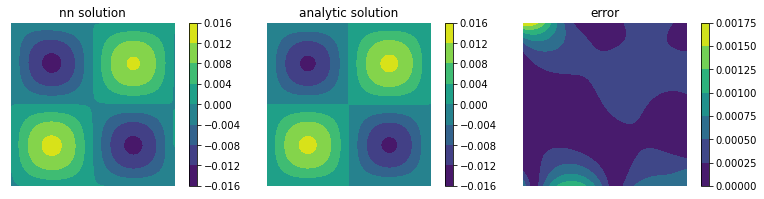

In [9]:
import matplotlib.pyplot as plt



def plot_solution(model, params, name=None):
    x = linspace(0, 1, 100)
    y = linspace(0, 1, 100)
    X, Y = meshgrid(x, y, indexing='xy')

    @jnp.vectorize
    def _sol(x, y):
        _x = stack((x, y))
        y = model.apply(params, _x)
        return y[0]

    def nn_sol(x, y):
        return _sol(x, y)

    def analytic_sol_func(x,y):
        return  sin(2 * pi * x) * sin(2 * pi * y) / (8 * pi ** 2)

    f = plt.figure(figsize=(13, 3))
    ax1, ax2, ax3 = f.subplots(1, 3)
    y_nn = nn_sol(X, Y)
    y_analytic = analytic_sol_func(X, Y)

    plt.sca(ax1)
    plt.axis('equal')
    plt.title("nn solution")
    p = plt.contourf(X, Y, y_nn)
    plt.colorbar(p)
    plt.axis("off")

    plt.sca(ax2)
    plt.axis('equal')
    plt.title("analytic solution")
    plt.contourf(X, Y, y_analytic)
    plt.colorbar()
    plt.axis("off")

    plt.sca(ax3)
    plt.axis('equal')
    plt.title("error")
    p = plt.contourf(X, Y, abs(y_nn - y_analytic))
    plt.colorbar(p)
    plt.axis("off")
    if name is not None:
        plt.savefig(name)

plot_solution(model, {'params': state.params})